In [24]:
# from pathlib import Path
# file="/home/davide/Desktop/genomiChro/proteine_RefSeq/Chroococcidiopsis_sp._CCMEE_29_GCF_023558375.1.faa"
# database_dir=Path("/home/davide/Desktop/genomiChro/database_RefSeq")
# #make blastp of the protein sequences in file against thew databases in database_dir
# import os
# import subprocess
# for db in database_dir.iterdir():
#     if db.is_file() and db.suffix==".pdb":
#         outdir=Path("/home/davide/Desktop/genomiChro/blastp_RefSeq_CCMEE29VSALL")
#         out=outdir/(db.stem+".txt")
#         print(out)
#         subprocess.run(["blastp", "-query", file, "-db", db.stem, "-out", out, "-outfmt", "6 qseqid sseqid stitle pident length evalue"])


/home/davide/Desktop/genomiChro/blastp_RefSeq_CCMEE29VSALL/Chroococcidiopsis_sp._CCMEE_29_GCF_023558375.1.txt
/home/davide/Desktop/genomiChro/blastp_RefSeq_CCMEE29VSALL/Chroococcidiopsis_cubana_CCALA_043_GCF_003003835.1.txt
/home/davide/Desktop/genomiChro/blastp_RefSeq_CCMEE29VSALL/Chroococcidiopsis_sp._[FACHB-1243]_GCF_014696895.1.txt
/home/davide/Desktop/genomiChro/blastp_RefSeq_CCMEE29VSALL/Chroococcidiopsis_sp._SAG_2025_GCF_032860985.1.txt
/home/davide/Desktop/genomiChro/blastp_RefSeq_CCMEE29VSALL/Chroococcidiopsis_cubana_SAG_39.79_GCF_034438355.1.txt
/home/davide/Desktop/genomiChro/blastp_RefSeq_CCMEE29VSALL/Chroococcidiopsis_sp._TS-821_GCF_002939305.1.txt
/home/davide/Desktop/genomiChro/blastp_RefSeq_CCMEE29VSALL/Chroococcidiopsis_sp._CCALA_051_GCF_003015105.1.txt
/home/davide/Desktop/genomiChro/blastp_RefSeq_CCMEE29VSALL/Chroococcidiopsis_thermalis_PCC_7203_GCF_000317125.1.txt
/home/davide/Desktop/genomiChro/blastp_RefSeq_CCMEE29VSALL/Chroococcidiopsis_sp._CCNUC1_GCF_023546805.1

In [4]:
from pathlib import Path

import Bio.motifs

genomi_dir=Path("/home/davide/Desktop/genomiChro/annotati_Refseq")
from intergeniche import sequenze_intergenichetutte
for file in genomi_dir.iterdir():
    if file.is_file() and file.suffix==".gbff":
        name=file.stem
        sequenze_intergenichetutte(file, f"/home/davide/Desktop/genomiChro/intergeniche_RefSeq/{name}_intergen-300+50.fasta", 300,op=False, c=50)

In [4]:
import re
s="CCAGAGTACAGGTCTAGGCA"
# Using [^A]
print(re.findall( ".{4}AGT.{4,10}[^A]CTA.{4}", s))  # Output: ['B', 'C']

# Using (?<!A)
print(re.findall( ".{4}AGT.{3,10}(?<!A)CTA.{4}", s))  # Output: ['C']

['CCAGAGTACAGGTCTAGGCA']
['CCAGAGTACAGGTCTAGGCA']


In [5]:
from pathlib import Path

import pandas as pd

dir=Path("/home/davide/Desktop/genomiChro/intergeniche_RefSeq")
blastp_dir=Path("/home/davide/Desktop/genomiChro/blastp_RefSeq_CCMEE29VSALL")
genomi_dir=Path("/home/davide/Desktop/genomiChro/annotati_Refseq")
import re

# Define the motifs
motivi= [
    #".{4}AG[ATCG].{4,11}ACT.{4}",
   # ".{4}AG[ATCG].{4,11}[TG]CT.{4}",
    #".{4}AGT.{4,11}AC[AT].{4}",
    #".{4}AGT.{4,11}[TG]CT.{4}",
    #".{4}TGT.{4,11}AC[AT].{4}"
    ".{4}AGT.{4,11}ACT.{4}",
    ".{4}AGT.{3,10}(?<!A)CTA.{4}"
]
lista="""CHRO_RS19320
CLLPBCKN_RS00375
H6G17_RS24585
C7Y66_RS27865
C7B79_RS28055
N4J56_RS20665
B1A85_RS01045
M5J74_RS20665
LAU37_RS14470
""".split()
from Bio import SeqIO
df_locus=pd.DataFrame(columns=["qseqid"])
for file in dir.iterdir():
    if not file.is_file() or file.suffix!=".fasta":
        continue
    diz={}
    for record in SeqIO.parse(file, "fasta"):
        seq=str(record.seq)
        for m in motivi:
            for match in re.finditer(m, str(seq)):
                x=match.group()
                s,e=match.start(),match.end()
                s=s-len(record.seq)+50
                if m==".{4}AGT.{4,11}ACT.{4}":
                    gap=len(x)-14
                else:
                    gap=len(x)-15
                if record.id in diz:
                    diz[record.id].append((x,s,gap))
                else:
                    diz[record.id]=[(x,s,gap)]
                if record.id in lista:
                    print(record.id, x)
    df= pd.Series(diz).to_frame()
    df.reset_index(inplace=True)
    nome=file.stem[:-9]
    df.columns=["locus", nome]
    for file2 in blastp_dir.iterdir():
        if file2.stem[:-3] in file.stem:
            #merge the two dataframes on the protein id
            df2=pd.read_csv(file2, sep="\t", header=None)
            df2.columns=["qseqid", "pid", "stitle", "pident", "length", "evalue"]
            #delete duplicates in qseqid keeping first
            df2.drop_duplicates(subset="qseqid", keep="first", inplace=True)
            #find row with qseqid WP_250121220.1

    locus_to_pid={}
    for file3 in genomi_dir.iterdir():
        if file3.stem[:-3] in file.stem :
            for record in SeqIO.parse(file3, "genbank"):
                for feature in record.features:
                    if feature.type=="CDS":
                        locus_tag=feature.qualifiers["locus_tag"][0]
                        protein_id=feature.qualifiers.get("protein_id", [""])[0]
                        if protein_id:
                            locus_to_pid[locus_tag]=protein_id
                            
    df3=pd.Series(locus_to_pid).to_frame()
    df3.reset_index(inplace=True)
    df3.columns=["locus","pid"]
    df3.drop_duplicates(subset="locus", keep="first", inplace=True)
    df4=pd.merge(df2, df3, on="pid", how="inner")
   
    #sort the dataframe for the evalue and keep the first in duplicated locus
    df4.sort_values(by="evalue", inplace=True)
    df4.drop_duplicates(subset="locus", keep="first", inplace=True)
    df4.drop_duplicates(subset="qseqid", keep="first", inplace=True)
    df_loc=df4[["qseqid","locus"]].copy()
    df_loc = df_loc.rename(columns={'locus': nome})
    df_locus=pd.merge(df_loc, df_locus, on="qseqid", how="outer")
    if 'data' not in globals():
        data=pd.merge(df, df4, on="locus", how="inner")
        data.drop(columns=["stitle", "pident", "length", "evalue","locus","pid"], inplace=True)
    else:
        data_temp=pd.merge(df, df4, on="locus", how="inner")
        data_temp.drop(columns=[ "stitle", "pident", "length", "evalue","locus","pid"], inplace=True)
        data=pd.merge(data, data_temp, on="qseqid", how="outer")
data.set_index("qseqid", inplace=True)



H6G17_RS24585 TTGTAGTACGACTGTTCTAAGAG
CLLPBCKN_RS00375 TTGTAGTACGACTGTTCTAAGAG
C7B79_RS28055 TTGTAGTACGACTGTTCTAAGAG
N4J56_RS20665 TTGTAGTACGACTGTTCTAAGAG
M5J74_RS20665 TTGTAGTACGACTGTTCTAAGAG
C7Y66_RS27865 TTGTAGTACGACTGTTCTAAGAG
LAU37_RS14470 TTGTAGTACGAATGTTCTATAGA
CHRO_RS19320 TTGTAGTACGACTGTTCTAAGAG
B1A85_RS01045 AGCGAGTAATATTAAACTCAGT
B1A85_RS01045 ACTCAGTTACCTATTAC
B1A85_RS01045 TTGTAGTTTTTTTTGCTATTCG


In [2]:

# df_locus.to_excel("/home/davide/Desktop/pidCCMEE_locus.xlsx")

In [6]:
df_locus.set_index("qseqid", inplace=True)
df_locus.loc["WP_250121220.1"]

Chroococcidiopsis_sp._TS-821_GCF_002939305_interg               B1A85_RS01045
Chroococcidiopsis_thermalis_PCC_7203_GCF_000317125_interg        CHRO_RS19320
Chroococcidiopsis_sp._CCMEE_29_GCF_023558375_interg             LAU37_RS14470
Chroococcidiopsis_sp._CCALA_051_GCF_003015105_interg            C7Y66_RS27865
Chroococcidiopsis_sp._CCNUC1_GCF_023546805_interg               M5J74_RS20665
Chroococcidiopsis_sp._SAG_2025_GCF_032860985_interg             N4J56_RS20665
Chroococcidiopsis_cubana_CCALA_043_GCF_003003835_interg         C7B79_RS28055
Chroococcidiopsis_cubana_SAG_39.79_GCF_034438355.1_interg    CLLPBCKN_RS00375
Chroococcidiopsis_sp._[FACHB-1243]_GCF_014696895_interg         H6G17_RS24585
Name: WP_250121220.1, dtype: object

In [6]:
data
non_nan_count = data.notnull().sum(axis=1)

# Create a new column 'non_nan_count' in the DataFrame
data['non_nan_count'] = non_nan_count

# Sort the DataFrame by 'non_nan_count' in descending order
data = data.sort_values(by='non_nan_count', ascending=False)

# Drop the 'non_nan_count' column as it's no longer needed
data = data.drop(columns=['non_nan_count'])
data




,Chroococcidiopsis_sp._[FACHB-1243]_GCF_014696895_interg,Chroococcidiopsis_cubana_SAG_39.79_GCF_034438355.1_interg,Chroococcidiopsis_cubana_CCALA_043_GCF_003003835_interg,Chroococcidiopsis_sp._SAG_2025_GCF_032860985_interg,Chroococcidiopsis_sp._CCNUC1_GCF_023546805_interg,Chroococcidiopsis_sp._CCALA_051_GCF_003015105_interg,Chroococcidiopsis_sp._CCMEE_29_GCF_023558375_interg,Chroococcidiopsis_thermalis_PCC_7203_GCF_000317125_interg,Chroococcidiopsis_sp._TS-821_GCF_002939305_interg
qseqid,,,,,,,,,
WP_250123062.1,"[(TGGTAGTTGTTATTACCAACTACCC, -54, 11), (CATGAG...","[(TGGTAGTTGTCATTACCAACTACCC, -6, 11)]","[(TGGTAGTTGTCATTACCAACTACCC, -6, 11)]","[(CATGAGTCTCAAACTTTACTTGTT, -1, 10)]","[(TGGTAGTTGTCATTACCAACTACCC, -6, 11)]","[(TGGTAGTTGTCATTACCAACTACCC, -6, 11)]","[(GTGAAGTTGAAACTCGCC, -290, 4), (GTGAAGTTGAAAC...","[(TGGTAGTTGTCATTACCAACTACCC, -6, 11)]","[(GTAGAGTTCTTCGCTATCTT, -141, 5)]"
WP_250121522.1,"[(ATGTAGTAGCTTTTATGACTGTTT, -14, 10), (GTGTAGT...","[(ATGTAGTAGCTTTTATGACTGTTT, -14, 10)]","[(ATGTAGTAGCTTTTATGACTGTTT, -14, 10)]","[(ATGTAGTAGCTTGTGTAACTGTTT, -38, 10)]","[(ATGTAGTAGCTTTTATGACTGTTT, -14, 10)]","[(ATGTAGTAGCTTTTATGACTGTTT, -14, 10)]","[(TTTCAGTAGGCACTGGAT, -276, 4), (ATCGAGTCCTTGC...","[(ATGTAGTAGCTTTTATGACTGTTT, -14, 10)]","[(ATAGAGTGTTACAAGAATACTTCTG, -44, 11)]"
WP_250121876.1,"[(AATTAGTAAAATAGCCCTACAAA, -38, 8)]","[(AATGAGTAAAATAGCCCTACAAA, -38, 8)]","[(AATGAGTAAAATAGCCCTACAAA, -38, 8)]","[(GTGTAGTGATTGGTCACTGGTC, -94, 8), (AATTAGTAAA...","[(GAGCAGTGACCACCAACTACCA, -103, 8), (AATGAGTAA...","[(AATGAGTAAAATAGCCCTACAAA, -38, 8)]","[(TAGGAGTAGAATCAGGGCTAAACT, -73, 9)]","[(AATGAGTAAAATAGCCCTACAAA, -38, 8)]","[(TCCTAGTCTTAAGGGAACTTCGA, -108, 9), (TCAGAGTA..."
WP_250124730.1,"[(CACTAGTCAACATAATGACTGCTA, -231, 10), (GGTAAG...","[(CACTAGTCAACATAATGACTGCTA, -237, 10), (GGTAAG...","[(CACTAGTCAACATAATGACTGCTA, -237, 10), (GGTAAG...","[(CACTAGTCAACATAATGACTGCTA, -294, 10), (GGTAAG...","[(CACTAGTCAACATAATGACTGCTA, -237, 10), (GGTAAG...","[(CACTAGTCAACATAATGACTGCTA, -237, 10), (GGTAAG...","[(CGCCAGTTACCTGACCAACTCCTT, -197, 10), (ACACAG...","[(CACTAGTCAACATAATGACTGCTA, -237, 10), (GGTAAG...","[(CGCCAGTTACCTGACCGACTTCTT, -186, 10), (ATTGAG..."
WP_250125598.1,"[(TGGAAGTTCGTACTGATG, -279, 4)]","[(TGGAAGTTCGTACTGATG, -228, 4)]","[(TGGAAGTTCGTACTGATG, -228, 4)]","[(TGGAAGTTCGTACTGATG, -228, 4)]","[(TGGAAGTTCGTACTGATG, -228, 4)]","[(TGGAAGTTCGTACTGATG, -228, 4)]","[(GAAGAGTAAGTGCTATAAA, -30, 4)]","[(TGGAAGTTCGTACTGATG, -228, 4)]","[(GGAGAGTATAGATAAGCTAATTT, -134, 8)]"
...,...,...,...,...,...,...,...,...,...
WP_250122316.1,NaN,NaN,NaN,NaN,NaN,NaN,"[(CAGAAGTGATCTATAAACTTTCA, -40, 9), (CAGAAGTGA...",NaN,NaN
WP_250122317.1,"[(GGCAAGTATGCCAGTCTAGTTG, 27, 7)]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WP_250125688.1,NaN,NaN,NaN,NaN,NaN,NaN,"[(AAGTAGTATTAACATTGAACTGATA, -238, 11), (CATTA...",NaN,NaN


In [7]:
#now sort the dataframe for the most common gap in the row(the third element of the tuple)
from collections import Counter
def most_common(row):
    gaps=[]
    for item in row:
        if isinstance(item, list):
            gap=set([x[2] for x in item ])
            gaps.extend(gap)
    return Counter(gaps).most_common(1)[0]
data["gap"]=data.apply(lambda x: most_common(x), axis=1)
data

,Chroococcidiopsis_sp._[FACHB-1243]_GCF_014696895_interg,Chroococcidiopsis_cubana_SAG_39.79_GCF_034438355.1_interg,Chroococcidiopsis_cubana_CCALA_043_GCF_003003835_interg,Chroococcidiopsis_sp._SAG_2025_GCF_032860985_interg,Chroococcidiopsis_sp._CCNUC1_GCF_023546805_interg,Chroococcidiopsis_sp._CCALA_051_GCF_003015105_interg,Chroococcidiopsis_sp._CCMEE_29_GCF_023558375_interg,Chroococcidiopsis_thermalis_PCC_7203_GCF_000317125_interg,Chroococcidiopsis_sp._TS-821_GCF_002939305_interg,gap
qseqid,,,,,,,,,,
WP_250123062.1,"[(TGGTAGTTGTTATTACCAACTACCC, -54, 11), (CATGAG...","[(TGGTAGTTGTCATTACCAACTACCC, -6, 11)]","[(TGGTAGTTGTCATTACCAACTACCC, -6, 11)]","[(CATGAGTCTCAAACTTTACTTGTT, -1, 10)]","[(TGGTAGTTGTCATTACCAACTACCC, -6, 11)]","[(TGGTAGTTGTCATTACCAACTACCC, -6, 11)]","[(GTGAAGTTGAAACTCGCC, -290, 4), (GTGAAGTTGAAAC...","[(TGGTAGTTGTCATTACCAACTACCC, -6, 11)]","[(GTAGAGTTCTTCGCTATCTT, -141, 5)]","(11, 6)"
WP_250121522.1,"[(ATGTAGTAGCTTTTATGACTGTTT, -14, 10), (GTGTAGT...","[(ATGTAGTAGCTTTTATGACTGTTT, -14, 10)]","[(ATGTAGTAGCTTTTATGACTGTTT, -14, 10)]","[(ATGTAGTAGCTTGTGTAACTGTTT, -38, 10)]","[(ATGTAGTAGCTTTTATGACTGTTT, -14, 10)]","[(ATGTAGTAGCTTTTATGACTGTTT, -14, 10)]","[(TTTCAGTAGGCACTGGAT, -276, 4), (ATCGAGTCCTTGC...","[(ATGTAGTAGCTTTTATGACTGTTT, -14, 10)]","[(ATAGAGTGTTACAAGAATACTTCTG, -44, 11)]","(10, 7)"
WP_250121876.1,"[(AATTAGTAAAATAGCCCTACAAA, -38, 8)]","[(AATGAGTAAAATAGCCCTACAAA, -38, 8)]","[(AATGAGTAAAATAGCCCTACAAA, -38, 8)]","[(GTGTAGTGATTGGTCACTGGTC, -94, 8), (AATTAGTAAA...","[(GAGCAGTGACCACCAACTACCA, -103, 8), (AATGAGTAA...","[(AATGAGTAAAATAGCCCTACAAA, -38, 8)]","[(TAGGAGTAGAATCAGGGCTAAACT, -73, 9)]","[(AATGAGTAAAATAGCCCTACAAA, -38, 8)]","[(TCCTAGTCTTAAGGGAACTTCGA, -108, 9), (TCAGAGTA...","(8, 7)"
WP_250124730.1,"[(CACTAGTCAACATAATGACTGCTA, -231, 10), (GGTAAG...","[(CACTAGTCAACATAATGACTGCTA, -237, 10), (GGTAAG...","[(CACTAGTCAACATAATGACTGCTA, -237, 10), (GGTAAG...","[(CACTAGTCAACATAATGACTGCTA, -294, 10), (GGTAAG...","[(CACTAGTCAACATAATGACTGCTA, -237, 10), (GGTAAG...","[(CACTAGTCAACATAATGACTGCTA, -237, 10), (GGTAAG...","[(CGCCAGTTACCTGACCAACTCCTT, -197, 10), (ACACAG...","[(CACTAGTCAACATAATGACTGCTA, -237, 10), (GGTAAG...","[(CGCCAGTTACCTGACCGACTTCTT, -186, 10), (ATTGAG...","(10, 9)"
WP_250125598.1,"[(TGGAAGTTCGTACTGATG, -279, 4)]","[(TGGAAGTTCGTACTGATG, -228, 4)]","[(TGGAAGTTCGTACTGATG, -228, 4)]","[(TGGAAGTTCGTACTGATG, -228, 4)]","[(TGGAAGTTCGTACTGATG, -228, 4)]","[(TGGAAGTTCGTACTGATG, -228, 4)]","[(GAAGAGTAAGTGCTATAAA, -30, 4)]","[(TGGAAGTTCGTACTGATG, -228, 4)]","[(GGAGAGTATAGATAAGCTAATTT, -134, 8)]","(4, 8)"
...,...,...,...,...,...,...,...,...,...,...
WP_250122316.1,NaN,NaN,NaN,NaN,NaN,NaN,"[(CAGAAGTGATCTATAAACTTTCA, -40, 9), (CAGAAGTGA...",NaN,NaN,"(9, 1)"
WP_250122317.1,"[(GGCAAGTATGCCAGTCTAGTTG, 27, 7)]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(7, 1)"
WP_250125688.1,NaN,NaN,NaN,NaN,NaN,NaN,"[(AAGTAGTATTAACATTGAACTGATA, -238, 11), (CATTA...",NaN,NaN,"(11, 1)"


In [8]:
#now sort the dataframe for the gap
data.sort_values(by="gap", ascending=False, inplace=True)
data

,Chroococcidiopsis_sp._[FACHB-1243]_GCF_014696895_interg,Chroococcidiopsis_cubana_SAG_39.79_GCF_034438355.1_interg,Chroococcidiopsis_cubana_CCALA_043_GCF_003003835_interg,Chroococcidiopsis_sp._SAG_2025_GCF_032860985_interg,Chroococcidiopsis_sp._CCNUC1_GCF_023546805_interg,Chroococcidiopsis_sp._CCALA_051_GCF_003015105_interg,Chroococcidiopsis_sp._CCMEE_29_GCF_023558375_interg,Chroococcidiopsis_thermalis_PCC_7203_GCF_000317125_interg,Chroococcidiopsis_sp._TS-821_GCF_002939305_interg,gap
qseqid,,,,,,,,,,
WP_250123779.1,"[(GGCGAGTGGAAGAGACTGACTCTTG, -35, 11)]","[(AGCGAGTGGAAGAGACTGACTCTTG, -35, 11)]","[(AGCGAGTGGAAGAGACTGACTCTTG, -35, 11)]","[(GGCGAGTGGAAGAGACTGACTCTTG, -35, 11)]","[(AGCGAGTGGAAGAGACTGACTCTTG, -35, 11)]","[(AGCGAGTGGAAGAGACTGACTCTTG, -35, 11)]","[(AGCAAGTGGAAGTAATTTACTTCTT, -36, 11)]","[(AGCGAGTGGAAGAGACTGACTCTTG, -35, 11)]","[(GGCAAGTGGAAGTGAGTGACTTCTT, -36, 11), (GTATAG...","(11, 9)"
WP_250124755.1,"[(TGTGAGTTCAGTCCTGTAACTGGTT, -175, 11)]","[(TGTGAGTTCAGTCCTGTAACTGGTT, -175, 11)]","[(TGTGAGTTCAGTCCTGTAACTGGTT, -175, 11)]","[(TGTGAGTTCAGTCCTGTAACTGGTT, -175, 11)]","[(TGTGAGTTCAGTCCTGTAACTGGTT, -175, 11)]","[(TGTGAGTTCAGTCCTGTAACTGGTT, -175, 11)]","[(CATAAGTTCAGTCCTCTCACTGGTT, -171, 11), (GGTAA...","[(TGTGAGTTCAGTCCTGTAACTGGTT, -175, 11)]","[(TGCAAGTAACCTTTAATGACTGAGC, -219, 11), (CTTGA...","(11, 9)"
WP_250121966.1,"[(TTGTAGTTTGGCACTGAAG, -212, 5), (GGTGAGTCCACG...","[(TTGTAGTTTGGCACTAAAG, -212, 5), (GGTGAGTCCACG...","[(TTGTAGTTTGGCACTAAAG, -212, 5), (GGTGAGTCCACG...","[(TTGTAGTTTGACACTGAAG, -211, 5), (GGTGAGTCCATG...","[(TTGTAGTTTGGCACTAAAG, -212, 5), (GGTGAGTCCACG...","[(TTGTAGTTTGGCACTGAAG, -212, 5), (GGTGAGTCCACG...","[(CTTCAGTGCTTCCCCAAAACTCAAC, 4, 11)]","[(TTGTAGTTTGGCACTAAAG, -212, 5), (GGTGAGTCCACG...","[(CGGCAGTCGTGTCAACTTAAC, -262, 7), (CAGTAGTCAG...","(11, 9)"
WP_250125318.1,"[(TGTGAGTAGGCAAATATAACTACTG, -33, 11)]","[(TGTGAGTAGGCAAATATAACTACTG, -33, 11)]","[(TGTGAGTAGGCAAATATAACTACTG, -33, 11)]","[(TGTGAGTAGGCAAAAATAACTACTG, -33, 11)]","[(TGTGAGTAGGCAAATATAACTACTG, -33, 11)]","[(TGTGAGTAGGCAAATATAACTACTG, -33, 11)]","[(ACACAGTAAATTCAACTTATC, -82, 7), (TGTGAGTAGGC...","[(TGTGAGTAGGCAAATATAACTACTG, -33, 11)]","[(TGTGAGTAGGCAAAAATAACTATAT, -55, 11), (TGTGAG...","(11, 9)"
WP_250123999.1,"[(GGGCAGTTCTTACTCCTT, -261, 4), (CTGTAGTATATTG...","[(GGGCAGTTCTTACTCCTT, -261, 4), (CTGTAGTATATTG...","[(GGGCAGTTCTTACTCCTT, -261, 4), (CTGTAGTATATTG...","[(GGGCAGTTCTTACTCCTG, -261, 4), (CTGTAGTATATTG...","[(GGGCAGTTCTTACTCCTT, -261, 4), (CTGTAGTATATTG...","[(GGGCAGTTCTTACTCCTT, -261, 4), (CTGTAGTATATTG...","[(CCTAAGTTAATGTCTACTGGGT, -129, 8), (GCCTAGTAA...","[(GGGCAGTTCTTACTCCTT, -261, 4), (CTGTAGTATATTG...","[(TGCGAGTACGCACTCGGC, -206, 4), (TAGGAGTTGATGT...","(11, 8)"
...,...,...,...,...,...,...,...,...,...,...
WP_250125442.1,NaN,NaN,NaN,NaN,NaN,NaN,"[(ATGAAGTGCTCTAGCCC, -128, 2)]",NaN,NaN,"(2, 1)"
WP_250122951.1,NaN,NaN,NaN,NaN,NaN,NaN,"[(GCGCAGTCTGCTAGAAT, -117, 2)]",NaN,"[(ATAAAGTGCTGTTAATCTAGGTT, -285, 8)]","(2, 1)"
WP_250126657.1,NaN,NaN,NaN,NaN,NaN,NaN,"[(GAAAAGTCAGCTATTTT, -183, 2)]",NaN,NaN,"(2, 1)"


In [9]:
data.to_excel("/home/davide/Desktop/motivi_sortedgaps+50.xlsx")

In [8]:
def extract_fasta(ids, fasta_file, out):
    from Bio import SeqIO
    seqs=[]
    for record in SeqIO.parse(fasta_file, "fasta"):
        if record.id in ids:
               seqs.append(record)
    SeqIO.write(seqs, out, "fasta")

In [22]:
index_list="""WP_250123642.1
WP_250122188.1
WP_250122321.1
WP_250121568.1
WP_250125693.1
WP_250123267.1
WP_250125598.1
WP_250124373.1
WP_250121494.1
WP_250122150.1""".split()
selected_rows = df_locus.loc[index_list]
rows = selected_rows.values.tolist()
flattened = [item for sublist in rows for item in sublist]
in_file="/home/davide/Desktop/genomiChro/intergeniche_RefSeq/joined/joined.fasta"
out_file="/home/davide/Desktop/motivo4.fasta"
extract_fasta(flattened, in_file, out_file)


In [ ]:
df_locus=pd.read_excel("/home/davide/Desktop/pidCCMEE_locus.xlsx")

In [10]:
df_annotazione=pd.read_excel("/home/davide/Downloads/AnnotazioneProteineCCMEE29.xlsx")
#drop duplicates in protein_id
df_annotazione.drop_duplicates(subset="protein_id", keep="first", inplace=True)
df_annotazione

,protein_id,gene,GO_process,GO_component,GO_function,GO_process_pannzer2,KEGG_brite,KEGG_pathways
0,WP_250124752.1,zwf,['GO:0006098 - pentose-phosphate shunt [Eviden...,NaN,['GO:0004345 - glucose-6-phosphate dehydrogena...,GO:0006098 - pentose-phosphate shunt,ko04147 Exosome,"01100 Metabolic pathways, 01110 Biosynthesis o..."
2,WP_250123417.1,zds,NaN,NaN,NaN,GO:0016117 - carotenoid biosynthetic process,NaN,"01100 Metabolic pathways, 01110 Biosynthesis o..."
3,WP_250121918.1,yqeK,NaN,NaN,NaN,NaN,NaN,NaN
4,WP_250124094.1,ylqF,['GO:0042254 - ribosome biogenesis [Evidence I...,['GO:0005737 - cytoplasm [Evidence IEA]'],['GO:0003924 - GTPase activity [Evidence IEA]'...,NaN,ko03009 Ribosome biogenesis,NaN
5,WP_250123747.1,yidD,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
6661,WP_250123219.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6662,WP_250123218.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6663,WP_250123216.1,NaN,NaN,NaN,NaN,NaN,ko03036 Chromosome and associated proteins,04112 Cell cycle - Caulobacter
6664,WP_275983398.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
file_gbff="/home/davide/Desktop/genomiChro/annotati_Refseq/Chroococcidiopsis_sp._CCMEE_29_GCF_023558375.gbff"
from Bio import SeqIO
diz={}
for record in SeqIO.parse(file_gbff, "genbank"):
    for feature in record.features:
        if feature.type=="CDS":
            locus_tag=feature.qualifiers["locus_tag"][0]
            protein_id=feature.qualifiers.get("protein_id", [""])[0]
            product=feature.qualifiers.get("product", [""])[0]
            if protein_id:
                diz[protein_id]= product

In [11]:
df_motivi=data.copy()
df_motivi.index.rename('protein_id', inplace=True)
df_motivi=pd.merge(df_motivi, df_annotazione, on="protein_id", how="inner")
#sort the dataframe for the gap
df_motivi.sort_values(by="gap", ascending=False, inplace=True)
df_motivi.to_excel("/home/davide/Desktop/motivi_annotati.xlsx")

In [14]:
df_motivi
#add diz to the dataframe
df_motivi["product"]=df_motivi["protein_id"].map(diz)
df_motivi


,protein_id,Chroococcidiopsis_sp._[FACHB-1243]_GCF_014696895_interg,Chroococcidiopsis_cubana_SAG_39.79_GCF_034438355.1_interg,Chroococcidiopsis_cubana_CCALA_043_GCF_003003835_interg,Chroococcidiopsis_sp._SAG_2025_GCF_032860985_interg,Chroococcidiopsis_sp._CCNUC1_GCF_023546805_interg,Chroococcidiopsis_sp._CCALA_051_GCF_003015105_interg,Chroococcidiopsis_sp._CCMEE_29_GCF_023558375_interg,Chroococcidiopsis_thermalis_PCC_7203_GCF_000317125_interg,Chroococcidiopsis_sp._TS-821_GCF_002939305_interg,gap,gene,GO_process,GO_component,GO_function,GO_process_pannzer2,KEGG_brite,KEGG_pathways,product
0,WP_250123779.1,"[(GGCGAGTGGAAGAGACTGACTCTTG, -35, 11)]","[(AGCGAGTGGAAGAGACTGACTCTTG, -35, 11)]","[(AGCGAGTGGAAGAGACTGACTCTTG, -35, 11)]","[(GGCGAGTGGAAGAGACTGACTCTTG, -35, 11)]","[(AGCGAGTGGAAGAGACTGACTCTTG, -35, 11)]","[(AGCGAGTGGAAGAGACTGACTCTTG, -35, 11)]","[(AGCAAGTGGAAGTAATTTACTTCTT, -36, 11)]","[(AGCGAGTGGAAGAGACTGACTCTTG, -35, 11)]","[(GGCAAGTGGAAGTGAGTGACTTCTT, -36, 11), (GTATAG...","(11, 9)",NaN,NaN,NaN,NaN,"GO:0019685 - photosynthesis, dark reaction",NaN,"01100 Metabolic pathways, 01110 Biosynthesis o...",form I ribulose bisphosphate carboxylase large...
2,WP_250121966.1,"[(TTGTAGTTTGGCACTGAAG, -212, 5), (GGTGAGTCCACG...","[(TTGTAGTTTGGCACTAAAG, -212, 5), (GGTGAGTCCACG...","[(TTGTAGTTTGGCACTAAAG, -212, 5), (GGTGAGTCCACG...","[(TTGTAGTTTGACACTGAAG, -211, 5), (GGTGAGTCCATG...","[(TTGTAGTTTGGCACTAAAG, -212, 5), (GGTGAGTCCACG...","[(TTGTAGTTTGGCACTGAAG, -212, 5), (GGTGAGTCCACG...","[(CTTCAGTGCTTCCCCAAAACTCAAC, 4, 11)]","[(TTGTAGTTTGGCACTAAAG, -212, 5), (GGTGAGTCCACG...","[(CGGCAGTCGTGTCAACTTAAC, -262, 7), (CAGTAGTCAG...","(11, 9)",NaN,NaN,NaN,['GO:0008080 - N-acetyltransferase activity [E...,NaN,NaN,NaN,GNAT family N-acetyltransferase
3,WP_250125318.1,"[(TGTGAGTAGGCAAATATAACTACTG, -33, 11)]","[(TGTGAGTAGGCAAATATAACTACTG, -33, 11)]","[(TGTGAGTAGGCAAATATAACTACTG, -33, 11)]","[(TGTGAGTAGGCAAAAATAACTACTG, -33, 11)]","[(TGTGAGTAGGCAAATATAACTACTG, -33, 11)]","[(TGTGAGTAGGCAAATATAACTACTG, -33, 11)]","[(ACACAGTAAATTCAACTTATC, -82, 7), (TGTGAGTAGGC...","[(TGTGAGTAGGCAAATATAACTACTG, -33, 11)]","[(TGTGAGTAGGCAAAAATAACTATAT, -55, 11), (TGTGAG...","(11, 9)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,hypothetical protein
1,WP_250124755.1,"[(TGTGAGTTCAGTCCTGTAACTGGTT, -175, 11)]","[(TGTGAGTTCAGTCCTGTAACTGGTT, -175, 11)]","[(TGTGAGTTCAGTCCTGTAACTGGTT, -175, 11)]","[(TGTGAGTTCAGTCCTGTAACTGGTT, -175, 11)]","[(TGTGAGTTCAGTCCTGTAACTGGTT, -175, 11)]","[(TGTGAGTTCAGTCCTGTAACTGGTT, -175, 11)]","[(CATAAGTTCAGTCCTCTCACTGGTT, -171, 11), (GGTAA...","[(TGTGAGTTCAGTCCTGTAACTGGTT, -175, 11)]","[(TGCAAGTAACCTTTAATGACTGAGC, -219, 11), (CTTGA...","(11, 9)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,RNA-binding protein
11,WP_250121559.1,"[(CATAAGTTGATTTTTCTAACTCAAA, -94, 11), (CATAAG...","[(CACAAGTCGTTGATAACTGACA, -227, 8), (CATAAGTTG...","[(CACAAGTCGTTGATAACTGACA, -227, 8), (CATAAGTTG...","[(CACAAGTCGCTGATAACTGACA, -227, 8), (CATAAGTTG...","[(CACAAGTCGTTGATAACTGACA, -227, 8), (CATAAGTTG...","[(CACAAGTCGCTGATAACTGACA, -227, 8), (CATAAGTTG...","[(AGCTAGTTTTTACTACTATTA, -212, 7), (AAATAGTTAT...","[(CACAAGTCGTTGATAACTGACA, -227, 8), (CATAAGTTG...",NaN,"(11, 8)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,DUF3155 domain-containing protein
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4661,WP_250121964.1,NaN,NaN,NaN,NaN,NaN,NaN,"[(CTTGAGTCAGTCGCCCGACTCCAC, -299, 10), (GTCAAG...",NaN,NaN,"(2, 1)",NaN,NaN,NaN,['GO:0003824 - catalytic activity [Evidence IE...,NaN,ko01007 Amino acid related enzymes,"01100 Metabolic pathways, 01110 Biosynthesis o...",aminotransferase class IV
4660,WP_250122743.1,NaN,NaN,NaN,NaN,NaN,NaN,"[(GTGAAGTGCATATTTTCACTTTAT, -187, 10), (TCGCAG...",NaN,NaN,"(2, 1)",NaN,['GO:0006807 - nitrogen compound metabolic pro...,NaN,NaN,NaN,NaN,NaN,nitrilase-related carbon-nitrogen hydrolase
4659,WP_250121428.1,NaN,NaN,NaN,NaN,NaN,NaN,"[(GGGGAGTGCGAATTAAGAACTATGT, -21, 11), (CTCAAG...",NaN,NaN,"(2, 1)",NaN,NaN,NaN,NaN,GO:0008610 - lipid biosynthetic process,NaN,NaN,fatty acyl-AM

In [32]:
import os
os.chdir("/home/davide/Desktop/genomiChro/MEME")
for i in range(4, 12):  
    command = [
        "/home/davide/meme/bin/meme",
        f"/home/davide/Desktop/motivo{i}.fasta",
        "-dna",
        "-mod",
        "zoops",
        "-pal",
        "-minw",
        str(i+6),
        "-maxw",
        str(i+6+4),
        "-o",
        f"motivo{i}_zoops",
        "-nmotifs",
        "5"
    ]
    command2 = [
        "/home/davide/meme/bin/meme",
        f"/home/davide/Desktop/motivo{i}.fasta",
        "-dna",
        "-mod",
        "oops",
        "-pal",
        "-minw",
        str(i+6),
        "-maxw",
        str(i+6+4),
        "-o",
        f"motivo{i}_oops",
        "-nmotifs",
        "5"
    ]
    subprocess.run(command, check=True)
    subprocess.run(command2, check=True)
    



Writing results to output directory 'motivo4_zoops'.
BACKGROUND: using background model of order 0
PRIMARY (classic): n 90 p0 90 p1 0 p2 0
SEQUENCE GROUP USAGE-- Starts/EM: p0; Trim: p0; pvalue: p0; nsites: p0,p1,p2
SEEDS: maxwords 25069 highwater mark: seq 90 pos 290
Initializing the motif probability tables for 4 to 180 sites...
nsites = 180
Done initializing.

seqs=    90, min_w=  94, max_w=  300, total_size=    25069

motif=1
SEED DEPTHS: 2 4 8 16 32 64 90
SEED WIDTHS: 10 11 14 15
em: w=  15, psites=  90, iter=  40 
motif=2
SEED DEPTHS: 2 4 8 16 32 64 90
SEED WIDTHS: 10 11 14 15
em: w=  15, psites=  90, iter=  40 
motif=3
SEED DEPTHS: 2 4 8 16 32 64 90
SEED WIDTHS: 10 11 14 15
em: w=  15, psites=  90, iter=  40 
motif=4
SEED DEPTHS: 2 4 8 16 32 64 90
SEED WIDTHS: 10 11 14 15
em: w=  15, psites=  90, iter=  40 
motif=5
SEED DEPTHS: 2 4 8 16 32 64 90
SEED WIDTHS: 10 11 14 15
em: w=  15, psites=  90, iter=  40 
Writing results to output directory 'motivo5_zoops'.
BACKGROUND: using bac

In [28]:
os.system("type meme")

meme: not found


32512

In [33]:
#use streme
import os
os.chdir("/home/davide/Desktop/genomiChro/MEME")
for i in range(4, 12):  
    command = [
        "/home/davide/meme/bin/streme",
        "--p",
        f"/home/davide/Desktop/motivo{i}.fasta",
        "--nmotifs",
        "5",
        "--minw",
        str(i+6),
        "--maxw",
        str(i+6+4),
        "--o",
        f"motivo{i}_streme",
        "--bfile",
        "/home/davide/Desktop/Chroococcidiopsis_sp._CCMEE_29_GCF_023558375_intergen_background_model.txt"
    ]
    subprocess.run(command, check=True)

# Positive sequences "/home/davide/Desktop/motivo4.fasta" - training: 81 hold-out: 9
# Negative sequences are shuffled primary sequences (2-order) - training: 81 hold-out: 9
# Background model by --bfile /home/davide/Desktop/Chroococcidiopsis_sp._CCMEE_29_GCF_023558375_intergen_background_model.txt.
# Warning: Background order 2 requested but the given --bfile is only order 1.
#          Setting --order to 1.
# Background: A 0.295 C 0.207 G 0.209 T 0.288
# Background order: 1 Background size: 20
# Using Fisher Exact test for p-values.
# Building suffix tree of positive and negative sequences...
# SUFFIXTREE	0.00 seconds 	(cumulative 0.01 seconds)
# Adding sequence counts and p-values to nodes using depth first search...
# ADDCOUNTS	0.00 seconds 	(cumulative 0.05 seconds)
# Sorting 47077 initial seed nodes by p-value...
# SORTSEEDS	0.00 seconds 	(cumulative 0.05 seconds)
#   Evaluating the top 25 seeds (out of 47077) of each width in range [3, 14] ...

# EVALUATESEEDS	0.00 seconds 	(cum

In [37]:
#use fimo
import os
from pathlib import Path
dir=Path("/home/davide/Desktop/genomiChro/MEME/motivi")
motivi=["motivo8_oops", "motivo8_zoops"]
for motivo in motivi:
    command= [
        "/home/davide/meme/bin/fimo",
        "--o",
        f"/home/davide/Desktop/genomiChro/MEME/fimo_{motivo}",
        "--norc",
        f"/home/davide/Desktop/genomiChro/MEME/motivi/{motivo}.meme",
        "/home/davide/PycharmProjects/TESI2/intergeniche_RefSeq/Chroococcidiopsis_sp._CCMEE_29_GCF_023558375_intergen.fasta",
    ]
    subprocess.run(command, check=True)


Using motif +TAGTACAWWTGTACTA of width 16.
Finding best site passing the output threshold in each of the 5778 sequences.
Found a best site in 118 sequences.
Computing q-values.
# Computing q-values.
#   Estimating pi_0 from a uniformly sampled set of 10000 p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.964356
#   Estimated pi_0=0.981493
Using motif +TAGTACAWWTGTACTA of width 16.
Finding best site passing the output threshold in each of the 5778 sequences.
Found a best site in 131 sequences.
Computing q-values.
# Computing q-values.
#   Estimating pi_0 from a uniformly sampled set of 10000 p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.9306
#   Estimated pi_0=0.94432


In [4]:
import pandas as pd
fimo_zoops="/home/davide/Desktop/genomiChro/MEME/fimo_motivo8_zoops/fimo.tsv"
fimo_oops="/home/davide/Desktop/genomiChro/MEME/fimo_motivo8_oops/fimo.tsv"
fimo16="/home/davide/Desktop/genomiChro/intergeniche_RefSeq/fimo/Chroococcidiopsis_sp._CCMEE_29_GCF_023558375_intergen/fimo.tsv"
fimo_zoops=pd.read_csv(fimo_zoops, sep="\t")
fimo_zoops["score"]=fimo_zoops["score"].astype(str)+", p-value:"+fimo_zoops["p-value"].astype(str)+", q-value:"+fimo_zoops["q-value"].astype(str)
print(fimo_zoops.columns)
fimo_zoops.drop(columns=["p-value", "q-value","start","stop","motif_id",'motif_alt_id',"strand"], inplace=True)
fimo_oops=pd.read_csv(fimo_oops, sep="\t")
fimo_oops["score"]=fimo_oops["score"].astype(str)+", p-value:"+fimo_oops["p-value"].astype(str)+", q-value:"+fimo_oops["q-value"].astype(str)
fimo_oops.drop(columns=["p-value", "q-value","start","stop","motif_id",'motif_alt_id',"strand"], inplace=True)
fimo16=pd.read_csv(fimo16, sep="\t")
fimo16["score"]=fimo16["score"].astype(str)+", p-value:"+fimo16["p-value"].astype(str)+", q-value:"+fimo16["q-value"].astype(str)
fimo16.drop(columns=["p-value", "q-value","start","stop","motif_id",'motif_alt_id',"strand"], inplace=True)

#merge on sequence name outer
fimo=pd.merge(fimo_zoops, fimo_oops, on="sequence_name", how="outer", suffixes=("_new_zoops", "_new_oops"))
fimo=pd.merge(fimo, fimo16, on="sequence_name", how="outer")
fimo

Index(['motif_id', 'motif_alt_id', 'sequence_name', 'start', 'stop', 'strand',
       'score', 'p-value', 'q-value', 'matched_sequence'],
      dtype='object')


,sequence_name,score_new_zoops,matched_sequence_new_zoops,score_new_oops,matched_sequence_new_oops,score,matched_sequence
0,LAU37_RS00155,"19.8659, p-value:1.56e-07, q-value:0.0153",CAGTACGGATGTACTA,"17.0976, p-value:6.68e-07, q-value:0.0378",CAGTACGGATGTACTA,"16.4889, p-value:1.54e-06, q-value:0.0629",CAGTACGGATGTACTA
1,LAU37_RS00330,NaN,NaN,"10.1951, p-value:9.28e-05, q-value:0.845",TAGTGGTGCTGAACTG,NaN,NaN
2,LAU37_RS00380,"19.0732, p-value:2.77e-07, q-value:0.0194",CAGTACATTTGCACTG,"18.0976, p-value:2.01e-07, q-value:0.0158",CAGTACATTTGCACTG,"12.7667, p-value:1.46e-05, q-value:0.295",CAGTACATTTGCACTG
3,LAU37_RS00385,"18.9512, p-value:3.04e-07, q-value:0.0199",CAGTGCAAATGTACTG,"17.9756, p-value:2.37e-07, q-value:0.0173",CAGTGCAAATGTACTG,"12.6667, p-value:1.53e-05, q-value:0.295",CAGTGCAAATGTACTG
4,LAU37_RS00510,NaN,NaN,"12.5854, p-value:2.53e-05, q-value:0.444",GAGTGAATCTTAACTA,"10.3556, p-value:4.56e-05, q-value:0.437",GAGTGAATCTTAACTA
...,...,...,...,...,...,...,...
311,NaN,"nan, p-value:nan, q-value:nan",NaN,"nan, p-value:nan, q-value:nan",NaN,"nan, p-value:nan, q-value:nan",NaN
312,NaN,"nan, p-value:nan, q-value:nan",NaN,"nan, p-value:nan, q-value:nan",NaN,"nan, p-value:nan, q-value:nan",NaN
313,NaN,"nan, p-value:nan, q-value:nan",NaN,"nan, p-value:nan, q-value:nan",NaN,"nan, p-value:nan, q-value:nan",NaN
314,NaN,"nan, p-value:nan, q-value:nan",NaN,"nan, p-value:nan, q-value:nan",NaN,"nan, p-value:nan, q-value:nan",NaN


In [9]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
file="/home/davide/PycharmProjects/TESI2/annotati_Refseq/Chroococcidiopsis_sp._CCMEE_29_(cyanobacteria)_GCF_023558375.gbff"
diz={}
for record in SeqIO.parse(file, "genbank"):
    for feature in record.features:
        if feature.type=="CDS":
            locus_tag=feature.qualifiers["locus_tag"][0]
            protein_id=feature.qualifiers.get("protein_id", [""])[0]
            product=feature.qualifiers.get("product", [""])[0]
            diz[locus_tag]=(protein_id, product)
#make dataframe from dictionary as rows
df=pd.DataFrame.from_dict(diz, orient="index")
df.reset_index(inplace=True)
df.columns=["sequence_name", "protein_id", "product"]
df.to_csv("/home/davide/Desktop/genomiChro/annotati_Refseq/CCMEE29basicinfo.csv", index=False)

In [10]:
#merge the fimo dataframe with the basic info of the protein
fimo=pd.merge(fimo, df, on="sequence_name", how="inner")
fimo=

,sequence_name,score_new_zoops,matched_sequence_new_zoops,score_new_oops,matched_sequence_new_oops,score,matched_sequence,protein_id,product
0,LAU37_RS00155,"19.8659, p-value:1.56e-07, q-value:0.0153",CAGTACGGATGTACTA,"17.0976, p-value:6.68e-07, q-value:0.0378",CAGTACGGATGTACTA,"16.4889, p-value:1.54e-06, q-value:0.0629",CAGTACGGATGTACTA,WP_250123622.1,hypothetical protein
1,LAU37_RS00330,NaN,NaN,"10.1951, p-value:9.28e-05, q-value:0.845",TAGTGGTGCTGAACTG,NaN,NaN,WP_250123655.1,alkaline phosphatase D family protein
2,LAU37_RS00380,"19.0732, p-value:2.77e-07, q-value:0.0194",CAGTACATTTGCACTG,"18.0976, p-value:2.01e-07, q-value:0.0158",CAGTACATTTGCACTG,"12.7667, p-value:1.46e-05, q-value:0.295",CAGTACATTTGCACTG,WP_250123665.1,hybrid sensor histidine kinase/response regulator
3,LAU37_RS00385,"18.9512, p-value:3.04e-07, q-value:0.0199",CAGTGCAAATGTACTG,"17.9756, p-value:2.37e-07, q-value:0.0173",CAGTGCAAATGTACTG,"12.6667, p-value:1.53e-05, q-value:0.295",CAGTGCAAATGTACTG,WP_250123666.1,SMC family ATPase
4,LAU37_RS00510,NaN,NaN,"12.5854, p-value:2.53e-05, q-value:0.444",GAGTGAATCTTAACTA,"10.3556, p-value:4.56e-05, q-value:0.437",GAGTGAATCTTAACTA,WP_250123688.1,hypothetical protein
...,...,...,...,...,...,...,...,...,...
284,LAU37_RS31325,"6.21951, p-value:8.08e-05, q-value:0.674",CAGTGTACAGGTTCTA,NaN,NaN,NaN,NaN,,transposase
285,LAU37_RS31500,"5.69512, p-value:9.47e-05, q-value:0.698",AAGTTCTGTCACACTG,NaN,NaN,NaN,NaN,WP_256478919.1,ABC transporter substrate-binding protein
286,LAU37_RS31705,NaN,NaN,"10.939, p-value:6.41e-05, q-value:0.752",TAGATAATTTTGACTG,NaN,NaN,WP_256478738.1,hypothetical protein
287,LAU37_RS31805,"7.92683, p-value:4.77e-05, q-value:0.574",CAGAATAAATGTTCTC,NaN,NaN,"10.0222, p-value:5.26e-05, q-value:0.456",CAGAATAAATGTTCTC,WP_275983391.1,cupin domain-containing protein


In [11]:
df_annotazione=pd.read_excel("/home/davide/Downloads/AnnotazioneProteineCCMEE29.xlsx")
#drop duplicates in protein_id
df_annotazione.drop_duplicates(subset="protein_id", keep="first", inplace=True)
fimo=pd.merge(fimo, df_annotazione, on="protein_id", how="inner")
fimo

,sequence_name,score_new_zoops,matched_sequence_new_zoops,score_new_oops,matched_sequence_new_oops,score,matched_sequence,protein_id,product,gene,GO_process,GO_component,GO_function,GO_process_pannzer2,KEGG_brite,KEGG_pathways
0,LAU37_RS00155,"19.8659, p-value:1.56e-07, q-value:0.0153",CAGTACGGATGTACTA,"17.0976, p-value:6.68e-07, q-value:0.0378",CAGTACGGATGTACTA,"16.4889, p-value:1.54e-06, q-value:0.0629",CAGTACGGATGTACTA,WP_250123622.1,hypothetical protein,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LAU37_RS00330,NaN,NaN,"10.1951, p-value:9.28e-05, q-value:0.845",TAGTGGTGCTGAACTG,NaN,NaN,WP_250123655.1,alkaline phosphatase D family protein,NaN,NaN,NaN,NaN,NaN,NaN,"01100 Metabolic pathways, 01240 Biosynthesis o..."
2,LAU37_RS00380,"19.0732, p-value:2.77e-07, q-value:0.0194",CAGTACATTTGCACTG,"18.0976, p-value:2.01e-07, q-value:0.0158",CAGTACATTTGCACTG,"12.7667, p-value:1.46e-05, q-value:0.295",CAGTACATTTGCACTG,WP_250123665.1,hybrid sensor histidine kinase/response regulator,NaN,NaN,NaN,NaN,GO:0000160 - phosphorelay signal transduction ...,NaN,NaN
3,LAU37_RS00385,"18.9512, p-value:3.04e-07, q-value:0.0199",CAGTGCAAATGTACTG,"17.9756, p-value:2.37e-07, q-value:0.0173",CAGTGCAAATGTACTG,"12.6667, p-value:1.53e-05, q-value:0.295",CAGTGCAAATGTACTG,WP_250123666.1,SMC family ATPase,NaN,NaN,NaN,NaN,GO:0006302 - double-strand break repair,ko03400 DNA repair and recombination proteins,NaN
4,LAU37_RS00510,NaN,NaN,"12.5854, p-value:2.53e-05, q-value:0.444",GAGTGAATCTTAACTA,"10.3556, p-value:4.56e-05, q-value:0.437",GAGTGAATCTTAACTA,WP_250123688.1,hypothetical protein,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,LAU37_RS31300,"6.97561, p-value:6.42e-05, q-value:0.628",AAGTTCATAAATTCTA,NaN,NaN,NaN,NaN,WP_250126508.1,SufE family protein,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274,LAU37_RS31500,"5.69512, p-value:9.47e-05, q-value:0.698",AAGTTCTGTCACACTG,NaN,NaN,NaN,NaN,WP_256478919.1,ABC transporter substrate-binding protein,NaN,NaN,NaN,NaN,NaN,NaN,NaN
275,LAU37_RS31705,NaN,NaN,"10.939, p-value:6.41e-05, q-value:0.752",TAGATAATTTTGACTG,NaN,NaN,WP_256478738.1,hypothetical protein,NaN,NaN,NaN,NaN,NaN,NaN,NaN
276,LAU37_RS31805,"7.92683, p-value:4.77e-05, q-value:0.574",CAGAATAAATGTTCTC,NaN,NaN,"10.0222, p-value:5.26e-05, q-value:0.456",CAGAATAAATGTTCTC,WP_275983391.1,cupin domain-containing protein,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
fimo.to_excel("/home/davide/Desktop/fimocompareCCMEE29.xlsx")

In [ ]:
from Bio import motifs
from Bio.Seq import Seq
def create_motif(dataframe, lista_ids):
    dataframe.loc
    WP_250122517.1
WP_250121493.1
WP_250123933.1
WP_250121220.1

In [68]:
from Bio.Seq import Seq
from Bio import motifs
def create_motif(index_list, data):
    selected_rows = data.loc[index_list]
    instances = []
    for index, row in selected_rows.iterrows():
        gap = selected_rows["gap"].loc[index][0]
        for col in row.index:
            row[col]
            if col == "gap":
                continue
            for item in row[col]:
                if item[2] == gap:
                    if item[0][-7:-4] == "CTA":
                        instances.append(Seq(item[0][:-1]))
                    else:
                        instances.append(Seq(item[0]))
    m = motifs.create(instances)
    return m



In [61]:
df_motivi

,protein_id,Chroococcidiopsis_sp._[FACHB-1243]_GCF_014696895_interg,Chroococcidiopsis_cubana_SAG_39.79_GCF_034438355.1_interg,Chroococcidiopsis_cubana_CCALA_043_GCF_003003835_interg,Chroococcidiopsis_sp._SAG_2025_GCF_032860985_interg,Chroococcidiopsis_sp._CCNUC1_GCF_023546805_interg,Chroococcidiopsis_sp._CCALA_051_GCF_003015105_interg,Chroococcidiopsis_sp._CCMEE_29_GCF_023558375_interg,Chroococcidiopsis_thermalis_PCC_7203_GCF_000317125_interg,Chroococcidiopsis_sp._TS-821_GCF_002939305_interg,gap,gene,GO_process,GO_component,GO_function,GO_process_pannzer2,KEGG_brite,KEGG_pathways,product
0,WP_250123779.1,"[(GGCGAGTGGAAGAGACTGACTCTTG, -35, 11)]","[(AGCGAGTGGAAGAGACTGACTCTTG, -35, 11)]","[(AGCGAGTGGAAGAGACTGACTCTTG, -35, 11)]","[(GGCGAGTGGAAGAGACTGACTCTTG, -35, 11)]","[(AGCGAGTGGAAGAGACTGACTCTTG, -35, 11)]","[(AGCGAGTGGAAGAGACTGACTCTTG, -35, 11)]","[(AGCAAGTGGAAGTAATTTACTTCTT, -36, 11)]","[(AGCGAGTGGAAGAGACTGACTCTTG, -35, 11)]","[(GGCAAGTGGAAGTGAGTGACTTCTT, -36, 11), (GTATAG...","(11, 9)",NaN,NaN,NaN,NaN,"GO:0019685 - photosynthesis, dark reaction",NaN,"01100 Metabolic pathways, 01110 Biosynthesis o...",form I ribulose bisphosphate carboxylase large...
2,WP_250121966.1,"[(TTGTAGTTTGGCACTGAAG, -212, 5), (GGTGAGTCCACG...","[(TTGTAGTTTGGCACTAAAG, -212, 5), (GGTGAGTCCACG...","[(TTGTAGTTTGGCACTAAAG, -212, 5), (GGTGAGTCCACG...","[(TTGTAGTTTGACACTGAAG, -211, 5), (GGTGAGTCCATG...","[(TTGTAGTTTGGCACTAAAG, -212, 5), (GGTGAGTCCACG...","[(TTGTAGTTTGGCACTGAAG, -212, 5), (GGTGAGTCCACG...","[(CTTCAGTGCTTCCCCAAAACTCAAC, 4, 11)]","[(TTGTAGTTTGGCACTAAAG, -212, 5), (GGTGAGTCCACG...","[(CGGCAGTCGTGTCAACTTAAC, -262, 7), (CAGTAGTCAG...","(11, 9)",NaN,NaN,NaN,['GO:0008080 - N-acetyltransferase activity [E...,NaN,NaN,NaN,GNAT family N-acetyltransferase
3,WP_250125318.1,"[(TGTGAGTAGGCAAATATAACTACTG, -33, 11)]","[(TGTGAGTAGGCAAATATAACTACTG, -33, 11)]","[(TGTGAGTAGGCAAATATAACTACTG, -33, 11)]","[(TGTGAGTAGGCAAAAATAACTACTG, -33, 11)]","[(TGTGAGTAGGCAAATATAACTACTG, -33, 11)]","[(TGTGAGTAGGCAAATATAACTACTG, -33, 11)]","[(ACACAGTAAATTCAACTTATC, -82, 7), (TGTGAGTAGGC...","[(TGTGAGTAGGCAAATATAACTACTG, -33, 11)]","[(TGTGAGTAGGCAAAAATAACTATAT, -55, 11), (TGTGAG...","(11, 9)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,hypothetical protein
1,WP_250124755.1,"[(TGTGAGTTCAGTCCTGTAACTGGTT, -175, 11)]","[(TGTGAGTTCAGTCCTGTAACTGGTT, -175, 11)]","[(TGTGAGTTCAGTCCTGTAACTGGTT, -175, 11)]","[(TGTGAGTTCAGTCCTGTAACTGGTT, -175, 11)]","[(TGTGAGTTCAGTCCTGTAACTGGTT, -175, 11)]","[(TGTGAGTTCAGTCCTGTAACTGGTT, -175, 11)]","[(CATAAGTTCAGTCCTCTCACTGGTT, -171, 11), (GGTAA...","[(TGTGAGTTCAGTCCTGTAACTGGTT, -175, 11)]","[(TGCAAGTAACCTTTAATGACTGAGC, -219, 11), (CTTGA...","(11, 9)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,RNA-binding protein
11,WP_250121559.1,"[(CATAAGTTGATTTTTCTAACTCAAA, -94, 11), (CATAAG...","[(CACAAGTCGTTGATAACTGACA, -227, 8), (CATAAGTTG...","[(CACAAGTCGTTGATAACTGACA, -227, 8), (CATAAGTTG...","[(CACAAGTCGCTGATAACTGACA, -227, 8), (CATAAGTTG...","[(CACAAGTCGTTGATAACTGACA, -227, 8), (CATAAGTTG...","[(CACAAGTCGCTGATAACTGACA, -227, 8), (CATAAGTTG...","[(AGCTAGTTTTTACTACTATTA, -212, 7), (AAATAGTTAT...","[(CACAAGTCGTTGATAACTGACA, -227, 8), (CATAAGTTG...",NaN,"(11, 8)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,DUF3155 domain-containing protein
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4661,WP_250121964.1,NaN,NaN,NaN,NaN,NaN,NaN,"[(CTTGAGTCAGTCGCCCGACTCCAC, -299, 10), (GTCAAG...",NaN,NaN,"(2, 1)",NaN,NaN,NaN,['GO:0003824 - catalytic activity [Evidence IE...,NaN,ko01007 Amino acid related enzymes,"01100 Metabolic pathways, 01110 Biosynthesis o...",aminotransferase class IV
4660,WP_250122743.1,NaN,NaN,NaN,NaN,NaN,NaN,"[(GTGAAGTGCATATTTTCACTTTAT, -187, 10), (TCGCAG...",NaN,NaN,"(2, 1)",NaN,['GO:0006807 - nitrogen compound metabolic pro...,NaN,NaN,NaN,NaN,NaN,nitrilase-related carbon-nitrogen hydrolase
4659,WP_250121428.1,NaN,NaN,NaN,NaN,NaN,NaN,"[(GGGGAGTGCGAATTAAGAACTATGT, -21, 11), (CTCAAG...",NaN,NaN,"(2, 1)",NaN,NaN,NaN,NaN,GO:0008610 - lipid biosynthetic process,NaN,NaN,fatty acyl-AM

In [39]:
from Bio import motifs
m = motifs.create(instances)
m.weblogo("motif.png")

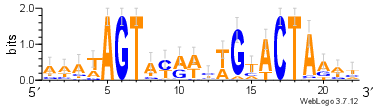

In [97]:
index_list = """WP_250122517.1
WP_250121493.1
WP_250123933.1
WP_250121220.1
WP_250121289.1
""".split()

m = create_motif(index_list, data)
m.weblogo("motif.png")
from IPython.display import Image
Image("motif.png")

In [ ]:
m.weblogo("/home/davide/motif.png")

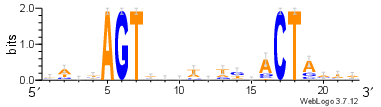

In [40]:
from IPython.display import Image
Image("motif.png")
m.

In [44]:
print(m.pssm)

        0      1      2      3      4      5      6      7      8      9     10     11     12     13     14     15     16     17     18     19     20     21
A:   0.39   0.95   0.46  -0.31   2.00   -inf   -inf   0.59   0.25   0.46   0.32   0.19  -0.10  -0.70   0.27   1.43   -inf   -inf   1.28   0.76   0.44   0.72
C:  -1.04  -2.24  -0.17  -0.70   -inf   -inf   -inf  -0.92   0.39  -0.07  -1.04  -0.20  -1.98  -1.47  -0.52  -0.98   2.00   -inf  -0.70  -0.98  -0.98  -0.52
G:   0.11  -0.43   0.02  -0.17   -inf   2.00   -inf  -0.07  -0.20   0.02  -1.47  -0.56  -0.28   0.83  -0.07  -0.86   -inf   -inf  -0.28  -0.14  -0.75  -0.81
T:   0.17   0.17  -0.47   0.76   -inf   -inf   2.00   0.02  -0.66  -0.61   0.93   0.39   0.99   0.32   0.19  -1.98   -inf   2.00  -2.98  -0.17   0.63   0.11


In [46]:
print(m.pssm)

        0      1      2      3      4      5      6      7      8      9     10     11     12     13     14     15     16     17     18     19     20     21
A:   0.39   0.95   0.46  -0.31   2.00   -inf   -inf   0.59   0.25   0.46   0.32   0.19  -0.10  -0.70   0.27   1.43   -inf   -inf   1.28   0.76   0.44   0.72
C:  -1.04  -2.24  -0.17  -0.70   -inf   -inf   -inf  -0.92   0.39  -0.07  -1.04  -0.20  -1.98  -1.47  -0.52  -0.98   2.00   -inf  -0.70  -0.98  -0.98  -0.52
G:   0.11  -0.43   0.02  -0.17   -inf   2.00   -inf  -0.07  -0.20   0.02  -1.47  -0.56  -0.28   0.83  -0.07  -0.86   -inf   -inf  -0.28  -0.14  -0.75  -0.81
T:   0.17   0.17  -0.47   0.76   -inf   -inf   2.00   0.02  -0.66  -0.61   0.93   0.39   0.99   0.32   0.19  -1.98   -inf   2.00  -2.98  -0.17   0.63   0.11


In [47]:
print(m.consensus)

AAATAGTACATTTGAACTAATA


In [48]:
print(m.degenerate_consensus)

NWNNAGTNNNWNNKNACTANNN


In [70]:
print(m.alphabet)


ACGT


<bound method Motif.reverse_complement of <Bio.motifs.Motif object at 0x7c9f4fe42d50>>


In [71]:
print(m.format("pfm"))

 26.00  22.00  29.00  15.00  48.00   0.00   0.00  29.00   2.00  27.00  26.00   5.00  17.00   3.00  10.00  38.00   0.00   0.00  43.00  26.00  19.00  10.00
  2.00   9.00   4.00   0.00   0.00   0.00   0.00   2.00  25.00   2.00   3.00  18.00   0.00   1.00  11.00   0.00  48.00   0.00   1.00   0.00   1.00  13.00
  9.00   1.00   8.00   6.00   0.00  48.00   0.00   7.00   2.00  18.00   0.00   8.00   1.00  44.00   1.00   0.00   0.00   0.00   3.00  13.00   9.00   3.00
 11.00  16.00   7.00  27.00   0.00   0.00  48.00  10.00  19.00   1.00  19.00  17.00  30.00   0.00  26.00  10.00   0.00  48.00   1.00   9.00  19.00  22.00


In [100]:
pwm= m.pwm
print(pwm)

        0      1      2      3      4      5      6      7      8      9     10     11     12     13     14     15     16     17     18     19     20     21
A:   0.54   0.46   0.60   0.31   1.00   0.00   0.00   0.60   0.04   0.56   0.54   0.10   0.35   0.06   0.21   0.79   0.00   0.00   0.90   0.54   0.40   0.21
C:   0.04   0.19   0.08   0.00   0.00   0.00   0.00   0.04   0.52   0.04   0.06   0.38   0.00   0.02   0.23   0.00   1.00   0.00   0.02   0.00   0.02   0.27
G:   0.19   0.02   0.17   0.12   0.00   1.00   0.00   0.15   0.04   0.38   0.00   0.17   0.02   0.92   0.02   0.00   0.00   0.00   0.06   0.27   0.19   0.06
T:   0.23   0.33   0.15   0.56   0.00   0.00   1.00   0.21   0.40   0.02   0.40   0.35   0.62   0.00   0.54   0.21   0.00   1.00   0.02   0.19   0.40   0.46


In [80]:
m.name="motivo8prova"


In [114]:
from Bio import motifs
from Bio.Seq import Seq

def motivo_to_meme(motif: motifs.Motif, out_file):
    pwm = motif.pwm
    df = pd.DataFrame(pwm)
    df_string = df.to_string(header=False, index=False)
    # Create the MEME Motif Format text
    meme_text = "MEME version 5.5\n\n"
    meme_text += f"ALPHABET= ACGT\n\n"
    meme_text += f"MOTIF {motif.degenerate_consensus} {motif.name}\n\n"
    meme_text += f"letter-probability matrix: alength= 4 w= {motif.length} nsites= {len(motif.alignment)} E= 0\n"
    meme_text += df_string
    # Write the MEME Motif Format text to a file
    with open(out_file, "w") as f:
        f.write(meme_text)
    return meme_text


In [116]:
m.name="motivo8prova"
x=motivo_to_meme(m, "/home/davide/Documents/motivo8prova.meme")
print(x)

MEME version 5.5

ALPHABET= ACGT

MOTIF AWAWAGTAYRWNWGTACTARWN motivo8prova

letter-probability matrix: alength= 4 w= 22 nsites= 48 E= 0
0.541667 0.041667 0.187500 0.229167
0.458333 0.187500 0.020833 0.333333
0.604167 0.083333 0.166667 0.145833
0.312500 0.000000 0.125000 0.562500
1.000000 0.000000 0.000000 0.000000
0.000000 0.000000 1.000000 0.000000
0.000000 0.000000 0.000000 1.000000
0.604167 0.041667 0.145833 0.208333
0.041667 0.520833 0.041667 0.395833
0.562500 0.041667 0.375000 0.020833
0.541667 0.062500 0.000000 0.395833
0.104167 0.375000 0.166667 0.354167
0.354167 0.000000 0.020833 0.625000
0.062500 0.020833 0.916667 0.000000
0.208333 0.229167 0.020833 0.541667
0.791667 0.000000 0.000000 0.208333
0.000000 1.000000 0.000000 0.000000
0.000000 0.000000 0.000000 1.000000
0.895833 0.020833 0.062500 0.020833
0.541667 0.000000 0.270833 0.187500
0.395833 0.020833 0.187500 0.395833
0.208333 0.270833 0.062500 0.458333


In [112]:
m.consensus

Seq('AAATAGTACAACTGTACTAAAT')

In [113]:
m.degenerate_consensus

Seq('AWAWAGTAYRWNWGTACTARWN')